# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project 3: Creating Customer Segments

Welcome to the third project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [25]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import renders as rs
from IPython.display import display # Allows the use of display() for DataFrames

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Load the wholesale customers dataset
try: 
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [26]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [27]:
# Select three indices of your choice you wish to sample from the dataset
import random

# idx1 = random.randint(0,440)
# idx2 = random.randint(0,440)
# idx3 = random.randint(0,440)
# Used random numbers a few times and I found the indices below had varying expenditures.
indices = [93, 200, 284]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,11314,3090,2062,35009,71,2698
1,3067,13240,23127,3941,9959,731
2,68951,4411,12609,8692,751,2406


### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  
*What kind of establishment (customer) could each of the three samples you've chosen represent?*  
**Hint:** Examples of establishments include places like markets, cafes, and retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant.

**Answer:**

For the indices I chose, which I found through a random number generator, I would postulate the following types of customers:

1. Customer 93: This customer has a significant frozen food expenditure, 35009, which is a little over 10x the average for the whole data set. The fresh and deli expenditures were within 2x the average amount. The detergents/paper products feature is way below average and milk is about half the average amount. Given this data, this customer could be a **fast food restaurant**, since they primarily use frozen foods.
2. Customer 200: This customer has grocery purchases about 3x higher than the average value in the data set. It also has above average expenditures in milk and detergents/paper. The remaining features are near average or below. This customer might be a **large grocery store that has less fresh products**. One example would be the Trader Joe's chain. 
3. Customer 284: The final customer has almost 6x the average expenditures for fresh food. They also have above average purchases for grocery and frozen products. The detergents/paper purchases are below average. This data indicates either a **high end natural foods market** or possibly a **high end restaurant**, since neither really needs to stock detergents/paper beyond what is needed for facility maintenance.

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [28]:
# Make a copy of the DataFrame, using the 'drop' function to drop the given feature
# features = ['Frozen','Fresh','Delicatessen','Milk','Detergents_Paper']
target = 'Grocery'
# Note: applied suggestions to tighten up this code from prior reviewer...it was quite ugly.
# feature_frame = data.drop(target,axis=1)
# print feature_frame.head()
# target_frame = data.drop(features,axis=1)
# print target_frame.head()
new_data = data.drop(target, axis=1)
new_data.head()

,Fresh,Milk,Frozen,Detergents_Paper,Delicatessen
0,12669,9656,214,2674,1338
1,7057,9810,1762,3293,1776
2,6353,8808,2405,3516,7844
3,13265,1196,6404,507,1788
4,22615,5410,3915,1777,5185


In [29]:
# Turn these frames into arrays to make regressor...
# feature_data = feature_frame[features]
# target_data = target_frame[target]

In [30]:
# Split the data into training and testing sets using the given feature as the target
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(new_data, data[target], test_size=0.25, random_state=7)
# X_train, X_test, y_train, y_test = train_test_split(feature_data, data, test_size=0.25, random_state=7)
print "Training data shape:"
print X_train.shape
print "Test data shape:"
print X_test.shape

Training data shape:
(330, 5)
Test data shape:
(110, 5)


In [31]:
# Create a decision tree regressor and fit it to the training set
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=1)
regressor.fit(X_train,y_train)

# TODO: Report the score of the prediction using the testing set
score = regressor.score(X_test,y_test)
print "Score = "
print score

Score = 
0.514800557572


### Question 2
*Which feature did you attempt to predict? What was the reported prediction score? Is this feature relevant for identifying a specific customer?*  
**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data.

**Answer:**

I ran my code several times, changing the target data. It was a **negative** value for Frozen, Fresh, Milk, and Delicatessen. From the hint, that means the regression failed - so the features do not appear to predict anything about customer purchases of those products. However, when I ran the regressor with Detergents_Paper and the model has an R^2 of about 0.748. When run with the Grocery target data, its R^2 score was about 0.513.

It appears that this study of the data shows that Detergents/Paper and Grocery are "predicatble" from the other features. Consequently, these two features will likely not identify customers, since the values can be predicted from the remaining features. The remaining features might tell us something about the customers, since they cannot be predicted from the data set.

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

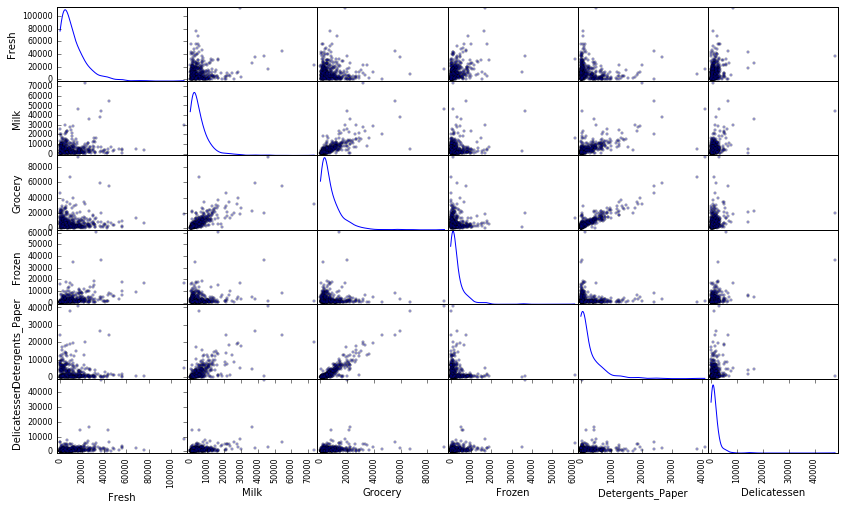

In [32]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Question 3
*Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?*  
**Hint:** Is the data normally distributed? Where do most of the data points lie? 

**Answer:**
The plot above shows what looks like a positive correlation for the following pair: Grocery - Detergents_Paper. So, if a customer purchases more grocery products, they appear to buy more Detergents_Paper products. There are some linear "clumps" - i.e. the clump is smudged along a line for the following pairs:

1. Milk - Detergents_Paper
2. Milk - Grocery

For these two pairs of features, most of the data is massed near the origin: under 20000 in both dimensions.

It appears that Delicatessen has a constant correlation among all of the other features, which is shown in the bottom row.

From my regression work, I hypothesized that Grocery and Detergents_Paper are important features. The matrix plot confirms this hypothesis since they have some linear correlation.

## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying a logarithm scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying a logrithm scaling. Again, use `np.log`.

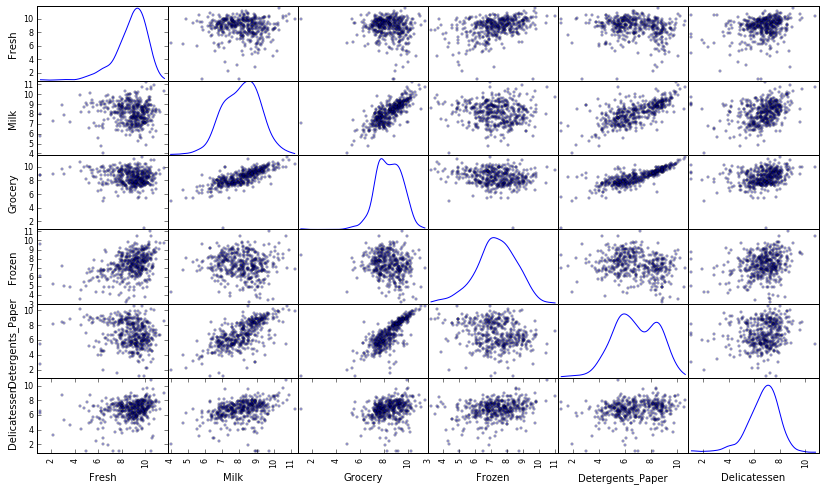

In [33]:
# Scale the data using the natural logarithm
from sklearn import preprocessing
xformer = preprocessing.FunctionTransformer(np.log)
log_data = xformer.fit_transform(data)
# Turn back into a data frame:
item_list = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicatessen']
log_dataframe = pd.DataFrame(log_data, columns=item_list)
# print log_data[:5]
# print log_dataframe.head()

# Scale the sample data using the natural logarithm
log_samples = xformer.fit_transform(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_dataframe, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

** Observations **
I originally flagged Milk-Grocery and Milk-Detergents_Paper as items that may be correlated. In this set of plots, those pairs are still correlated, but I see the addition of Grocery-Detergents_Paper.

In [34]:
# Display the log-transformed sample data
display(log_samples)

array([[  9.33379618,   8.03592637,   7.63143166,  10.46336045,
          4.26267988,   7.90026604],
       [  8.02845516,   9.49099783,  10.04875605,   8.27918978,
          9.20623194,   6.59441346],
       [ 11.14115139,   8.3918567 ,   9.44216612,   9.07015834,
          6.62140565,   7.7857209 ]])

### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

In [35]:
# For each feature find the data points with extreme high or low values
# outlier_map = {}
outlier_indices = np.array([])
for feature in log_dataframe.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_dataframe[feature], 25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_dataframe[feature], 75)
    IQR = Q3-Q1
    print "IQR for " + feature + ":"
    print IQR
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3-Q1)
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    outlier_frame = log_dataframe[~((log_dataframe[feature] >= Q1 - step) & (log_dataframe[feature] <= Q3 + step))]
    outlier_indices = np.append(outlier_indices, np.array(outlier_frame.index.values))
#     outlier_map[feature] = outlier_indices
    display(outlier_frame)

# print outlier_map
# for key in outlier_map:
#     print str(key)
#     common_indices = np.array([])
#     vs = np.array(outlier_map.values())
#     for i in range(1, vs.size):
#         print i
outlier_indices = np.sort(outlier_indices)
print outlier_indices
print np.unique(outlier_indices)
print outlier_indices.size
# Select the indices for data points you wish to remove    
outliers  = [65, 66, 75, 128, 154]

# Remove the outliers, if any were specified
good_data = log_dataframe.drop(log_dataframe.index[outliers]).reset_index(drop = True)
# print good_data.shape

IQR for Fresh:
1.68900524574
Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


IQR for Milk:
1.54549884855
Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


IQR for Grocery:
1.59923747586
Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


IQR for Frozen:
1.56621833401
Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


IQR for Detergents_Paper:
2.72623917396
Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


IQR for Delicatessen:
1.49485376961
Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


[  38.   57.   65.   65.   66.   66.   75.   75.   81.   86.   95.   96.
   98.  109.  128.  128.  137.  142.  145.  154.  154.  154.  161.  171.
  175.  183.  184.  187.  193.  203.  218.  233.  264.  285.  289.  304.
  305.  325.  338.  343.  353.  355.  356.  357.  412.  420.  429.  439.]
[  38.   57.   65.   66.   75.   81.   86.   95.   96.   98.  109.  128.
  137.  142.  145.  154.  161.  171.  175.  183.  184.  187.  193.  203.
  218.  233.  264.  285.  289.  304.  305.  325.  338.  343.  353.  355.
  356.  357.  412.  420.  429.  439.]
48


### Question 4
*Are there any data points considered outliers for more than one feature? Should these data points be removed from the dataset? If any data points were added to the `outliers` list to be removed, explain why.* 

**Answer:**

The code identifies if *any* of the six features is outside of the IQR for each customer. The data set has 440 points, and 48 unique customers that have at least one feature outlier. If we remove all 48, we would lose 10.9% of our data! However, many of these detected outliers are for *one feature*. More than likely a single feature would not indicate that the whole customer is an outlier. If we find customers with several outliers, more than likely that customer is an outlier data point. I decided that my threshold for outliers would require **two or more** features that are tagged as outside the IQR.

To detect these customers, I collected all of the outlier indices and sorted them. Then I used numpy's `unique()` function to create a new list with unique values. By manually inspection, I chose the indices: 65, 66, 75, 128, and 154. This set of outliers makes up only 1.13% of the data, so losing that information would likely not skew the results.



## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. 

In the code block below, you will need to implement the following:
 - Import `sklearn.preprocessing.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

[[-2.77968311  2.37426035  1.91207665  1.11648112 -0.6970312   0.06270272]
 [ 2.99033876  0.36445596  0.25212352  1.56527677 -0.1922364  -0.12443078]
 [-0.14263854  3.14773718 -0.34352761  0.31487891 -0.34533992 -0.82241007]]


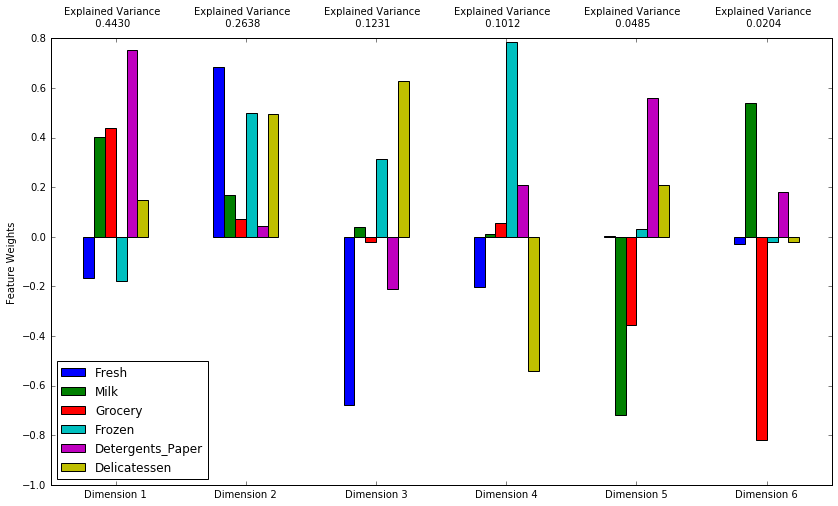

In [36]:
# Apply PCA to the good data with the same number of dimensions as features
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(good_data)

# Apply a PCA transformation to the sample log-data
pca_samples = pca.transform(log_samples)
print pca_samples

# Generate PCA results plot
pca_results = rs.pca_results(good_data, pca)

### Question 5
*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the indivdual feature weights.

**Answer:**

The first and second component explain around 70% of the variance of this data. The first four components explain 93% of the variance!

After performing some more research (especially this [helpful reference](https://onlinecourses.science.psu.edu/stat505/node/54))), interpreting these scores depends on the cutoff for feature weights. In this problem, I will choose +/- 0.2 to set the importance of a particular feature on the principal component.

The first principal component (PC1) explains 0.4430 of the variance. Based on my cutoff assumption, the key features are detergents/paper, milk, and grocery. PC1 has strong correlations with those products, i.e. if a customer increases any/all of those values, then PC1 will increase. Consequently, PC1 indicates how much a customer spends on **retail products**.

PC2, which explains 0.2638 of the variance, has strong positive correlation with fresh, frozen, and delicatessen products. Again, since these features have positive weights, if a customer purchases any/all products in this category, the value of PC2 will increase. PC2 indicates how much a customer spends on **perishable food products**.

PC3 explains a smaller amount of variance, 0.1231. The key features that matter to PC3 are deli and frozen (positive correlation) and fresh (negative correlation). The high negative weight on the fresh feature means that PC3 increases when there are **less** fresh purchases made by a customer. I think that PC3 indicates how much a customer spends on **prepared foods**. For example, a small cafe without much room might store more prepared food products.

The final component, PC4, explains only 0.1012 of the total variance. It has a very high correlation with frozen products, but a high *negative* correlation with delicatessen products. PC4 appears to indicate restaurants or stores that focus on frozen products alone. The negative correlation to delicatessen tells me that increasing the value of this PC indicates a customer that **stores and uses frozen products**. I think a typical customer that might have a high value for PC4 would be a fast food store *or* a wholesale warehouse.

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [37]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-2.7797,2.3743,1.9121,1.1165,-0.6970,0.0627
1,2.9903,0.3645,0.2521,1.5653,-0.1922,-0.1244
2,-0.1426,3.1477,-0.3435,0.3149,-0.3453,-0.8224


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the reuslts to `reduced_data`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [38]:
# Fit PCA to the good data using only two dimensions
pca = PCA(n_components=2)
pca.fit(good_data)
# Apply a PCA transformation the good data
reduced_data = pca.transform(good_data)

# Apply a PCA transformation to the sample log-data
# Note: applied fix from reviewer - do not perform another fit! Just a transform.
pca_samples = pca.transform(log_samples)
print pca_samples

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

[[-2.77968311  2.37426035]
 [ 2.99033876  0.36445596]
 [-0.14263854  3.14773718]]


### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [39]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-2.7797,2.3743
1,2.9903,0.3645
2,-0.1426,3.1477


## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6
*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*

**Answer:**

For KMeans, one advantage is its intuitive concept: select a number of clusters, let the algorithm iterate to find the "best" locations for the center of the clusters. Another advantage is that its runtime is polynomial, O(n^3). Finally, it is adaptable to different notions of distance, such as average or median.

Gaussian Mixture Models (GMM) have one advantage over KMeans: they handle ambiguous data gracefully by providing a "soft" assignment of cluster based on Gaussian distributions. This capability is the result of leveraging expectation maximization. Much like KMeans, it is also amenable to other distributions, instead of Gaussian.

I plan to use GMM, since there may be situations where a customer my be on the "border" of two different categories. I would like to properly capture these edge cases.

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import sklearn.metrics.silhouette_score and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [40]:
# Apply your clustering algorithm of choice to the reduced data 
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from sklearn import metrics

sil_scores = np.array([])
# Iterate n_clusters from 2 to 8.
for n in range(2,9):
    clusterer = GMM(n_components=n)
    # clusterer = KMeans(n_clusters=2)
    clusterer.fit(reduced_data)

    # Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # Find the cluster centers
    centers = clusterer.means_
    # centers = clusterer.cluster_centers_

    # Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = metrics.silhouette_score(reduced_data, preds)
    sil_scores = np.append(sil_scores, score)

### Question 7
*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 

In [41]:
print sil_scores

[ 0.41181886  0.37356075  0.33331261  0.28098341  0.28606686  0.30908367
  0.30942406]


**Answer:**

It is clear from the score array, `sil_scores`, using a cluster value of `n_clusters=2` will produce the best clustering of customers.

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

[[-1.30917139  0.1428472 ]
 [ 1.63707508 -0.17862565]]


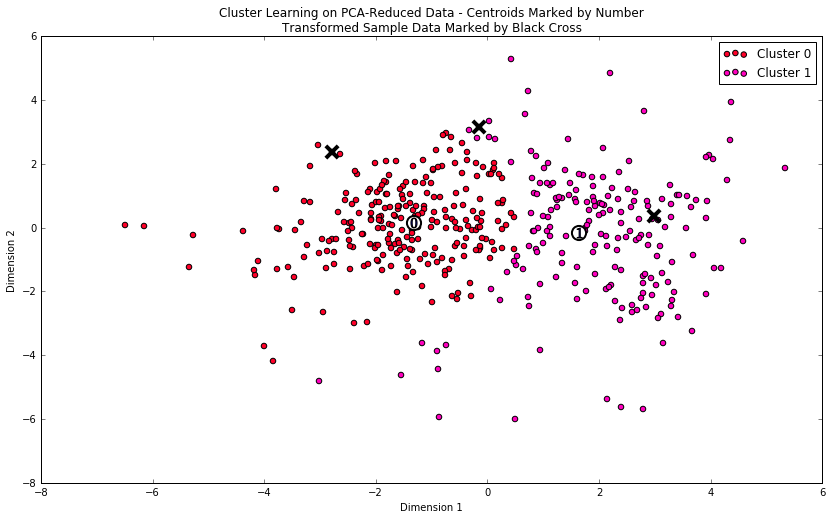

In [42]:
clusterer = GMM(n_components=2, random_state=42)
clusterer.fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.means_
sample_preds = clusterer.predict(pca_samples)

# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, centers, pca_samples)
print centers

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


In [43]:
# Inverse transform the centers
log_centers = pca.inverse_transform(centers)
# print log_centers

# Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)
# Comparing the centers to the means of the data.
print "Distance from feature means:"
display(true_centers - np.exp(good_data.mean()).astype(int))

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8812,2052,2689,2058,337,712
Segment 1,4316,6347,9555,1036,3046,945


Distance from feature means:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,2396,-1337,-2034,541,-559,-95
Segment 1,-2100,2958,4832,-481,2150,138


### Question 8
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*  
**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`.

**Answer:**

The average customer associate with Segment 0 appears to be a has higher *average expenditures* in the fresh and frozen categories. Customers in this segment would likely be restaurants or small markets that do not need to carry standard grocery items or detergents/paper products.

The average customer clustered into Segment 1 purchases *on average* more milk, grocery, and detergents/paper products and a little more deli. I would members of this category align with retail grocery stores or big box department stores, i.e. Target.

### Question 9
*For each sample point, which customer segment from* ***Question 8*** *best represents it? Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [44]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred
    print samples.iloc[[i]]
display(true_centers)

Sample point 0 predicted to be in Cluster 0
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  11314  3090     2062   35009                71          2698
Sample point 1 predicted to be in Cluster 1
   Fresh   Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
1   3067  13240    23127    3941              9959           731
Sample point 2 predicted to be in Cluster 1
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
2  68951  4411    12609    8692               751          2406


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8812,2052,2689,2058,337,712
Segment 1,4316,6347,9555,1036,3046,945


**Answer:**

From my sample data, customers indexed at 0 is in Cluster 0. The other two sample points fall in Cluster 1. 

In this case, I notice that sample point 2 is an ambiguous customer that was placed in cluster 1. From the statistical data and the sample point data, it has a couple more feature points in common with sample point 0 (e.g. above average frozen, below average detergents/paper). It also has far more fresh expenditures that its cluster "neighbor," sample point 1. Perhaps applying KMeans would align this data point in Cluster 0.

Despite this discrepancy, the clustering assignments mostly align with the sample data. Sample point 0 is assigned to Cluster 0, which has higher average fresh and frozen expenditures. That customer has a Fresh value of 11314, which is greater than the cluster average. It also has a very large frozen value that is consistent with the clustering assignment. Sample points 1 and 2 were placed in Cluster 1, which has higher average milk, grocery, detergents/paper, and deli. Sample point 1 fits this assignment well given the data: milk = 13240, grocery = 23127, and detergents/paper = 9959. Sample point 2 is an odd bird, as I previously identified, because of its large fresh expenditure, 68951. But, its grocery, detergents/paper, and deli costs push it into Cluster 1.

## Conclusion

### Question 10
*Companies often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services. If the wholesale distributor wanted to change its delivery service from 5 days a week to 3 days a week, how would you use the structure of the data to help them decide on a group of customers to test?*  
**Hint:** Would such a change in the delivery service affect all customers equally? How could the distributor identify who it affects the most?

**Answer:**

The analysis above identified two clusters: one with a high dependency on fresh products and the other with dependencies on milk, grocery, and detergents/paper. I would propose the following test for the company:

* Create a control group that is a randomly sampled from the customers in cluster 0.
* Create a hypothesis group that is composed of all remaining customers in cluster 0.
* Keep the control group at the 5 day a week delivery; switch the hypothesis group to 3 days a week.
* If a majority of the hypothesis group complains about the revised delivery schedule, then the test would validate that customers with high fresh product dependencies (cluster 0) should *not* be switched.

### Question 11
*Assume the wholesale distributor wanted to predict some other feature for each customer based on the purchasing information available. How could the wholesale distributor use the structure of the data to assist a supervised learning analysis?*

**Answer:**

The clustering analysis on this customer data produced two segments: "fresh market/retaurant" category (Segment 0) and "grocery retailer" (Segment 1). We apply the clustering to all data points to create new binary features that indicate if the customer is in one of those categories.

The wholesale distributor could use the augmented features to build a supervised learner that could identify one of the following things (though there are likely more):

* Predicted expenditures of a feature category, for example, how much would a new customer likely spend on fresh products given their segment and their other expenditures.
* The assignemnt of delivery schedule for current and new customers.

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier on to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

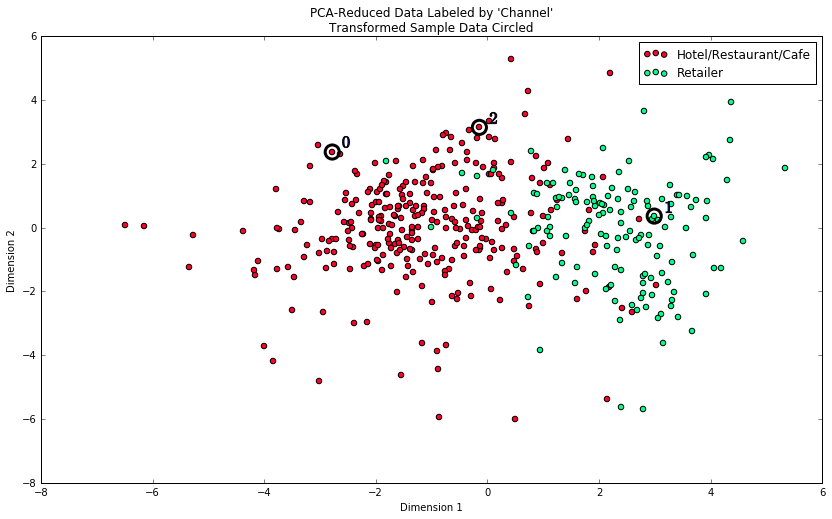

In [45]:
# Display the clustering results based on 'Channel' data
rs.channel_results(reduced_data, outliers, pca_samples)

### Question 12
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*

**Answer:**

In the plot above, my chosen clustering algorithm (GMM) aligns the segments as follows:

1. Segment 0 = Hotel/Restaurant/Cafe
2. Segment 1 = Retailer

I notice that within each cluster, there are errors in classification. For example, in the Retailer data, there are about two dozen Restaurant/Hotel/Cafe customers. Cluster segment 0, which represents the Hotel/Restaurant/Cafe customers, has about 10-12 retailer data points.

Despite these errors, it captures the larger behavior of these different types of customers. I have seen the line blur between Retailer and Hotel/Restaurant/Cafe, as many retail stores have at least a Deli or Coffee shop embedded.

After a more detailed inspection along each dimension, it appears that more negative values for Dim 1 result in a closer alignment to the Hotel/Restaurant/Cafe group. The bar plot for Dim 1 shows that Detergents_Paper is a dominant feature to that component. This result is expected since I would likely not buy a cleaning supplies and paper from a restaurant!

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.